In [12]:
import pandas as pd
import seaborn as sns
import scipy.stats as st
import scipy
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
from functools import partial


In [13]:
if not os.path.exists('constituents-financials.csv'):
    urllib.request.urlretrieve("https://datahub.io/core/s-and-p-500-companies-financials/r/constituents-financials.csv", "constituents-financials.csv")

data = pd.read_csv('constituents-financials.csv')
data


,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,138721055226,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,10783419933,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,102121042306,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,181386347059,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,98765855553,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,XYL,Xylem Inc.,Industrials,70.24,30.94,1.170079,1.83,76.81,46.860,12915021000,7.220000e+08,2.726209,5.31,http://www.sec.gov/cgi-bin/browse-edgar?action...
501,YUM,Yum! Brands Inc,Consumer Discretionary,76.30,27.25,1.797080,4.07,86.93,62.850,27003303098,2.289000e+09,6.313636,212.08,http://www.sec.gov/cgi-bin/browse-edgar?action...
502,ZBH,Zimmer Biomet Holdings,Health Care,115.53,14.32,0.794834,9.01,133.49,108.170,24454698119,2.007400e+09,3.164895,2.39,http://www.sec.gov/cgi-bin/browse-edgar?action...
503,ZION,Zions Bancorp,Financials,50.71,17.73,1.480933,2.60,55.61,38.430,10670678640,0.000000e+00,3.794579,1.42,http://www.sec.gov/cgi-bin/browse-edgar?action...


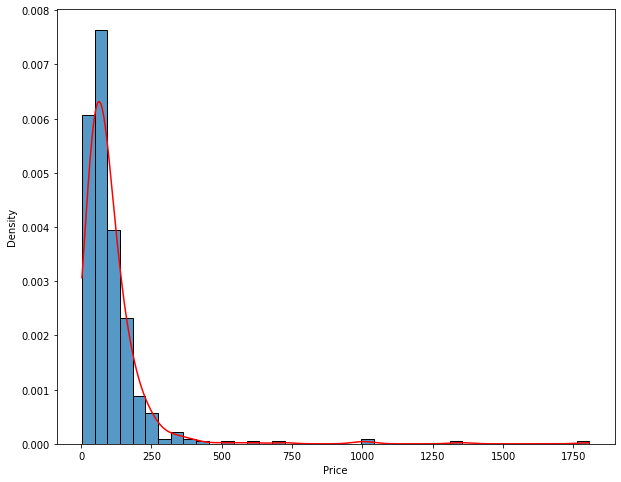

In [14]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(data.Price)
print(kernel)
min_amount, max_amount = data.Price.min(), data.Price.max()
x = np.linspace(min_amount, max_amount, len(data.Price))
kde_values = kernel(x)

sns.histplot(data.Price, kde=False, bins=40, stat='density', label=f'Average price in dollars')
plt.plot(x, kde_values, color='r')

iqr 70.29
1/4 quantile 46.25 3/4 quantile 116.54
min -59.185 max 151.685
median 73.92


<AxesSubplot:>

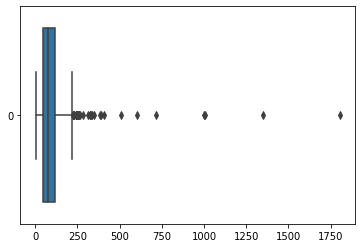

In [15]:
price = data.Price
# price = price[price.between(price.min(), price.quantile(.99))].reset_index(drop=True)

q1 = price.quantile(0.25)
q3 = price.quantile(0.75)
iqr =  q3 -  q1
print('iqr', iqr)
print('1/4 quantile', price.quantile(1/4), '3/4 quantile', price.quantile(3/4))
print('min', q1-1.5*iqr, 'max', q1+1.5*iqr)
print('median', price.median())
sns.boxplot(data=price, orient='h')

s = 0.7564047240073324, loc = -1.6683261653102743, scale = 76.34224847520608


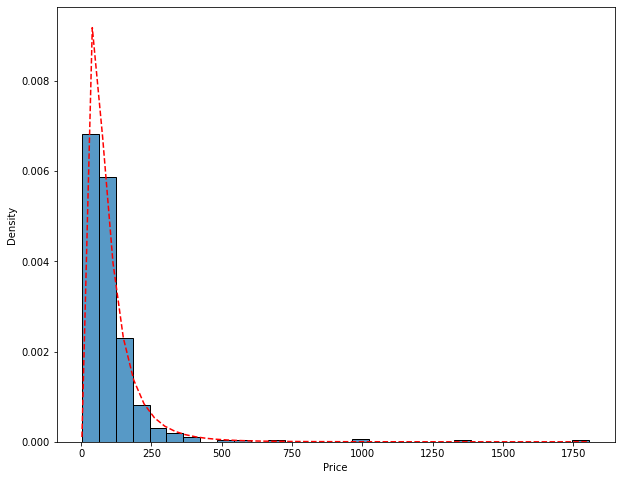

In [16]:
plt.figure(figsize=(10, 8))
x = np.linspace(np.min(price), np.max(price))
params_lognorm = scipy.stats.lognorm.fit(price)
print(f's = {params_lognorm[0]}, loc = {params_lognorm[1]}, scale = {params_lognorm[2]}')
sns.histplot(price, kde=False, bins=30, stat='density', label=f'Average price in dollars')
pdf = scipy.stats.lognorm.pdf((x - params_lognorm[1]) / params_lognorm[2], params_lognorm[0]) / params_lognorm[2]
plt.plot(x, pdf, 'r--')
plt.show()

<AxesSubplot:xlabel='Price', ylabel='Density'>

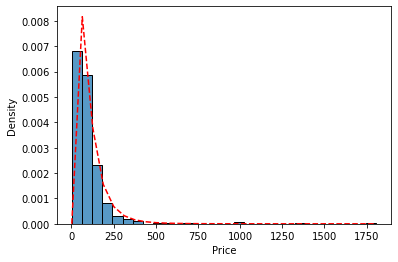

In [17]:
def lognorm_pdf(x, mu, sigma):
    exp = np.exp(-(np.log(x) - mu)**2 / (2 * sigma ** 2))

    frac =  (x * sigma * (2 * np.pi) ** 0.5)
    return exp / frac

hist, bin_edges = np.histogram(price, bins=30, density=True)

freq = [hist[i] for i in range(len(hist) - 1)]
positions = [(bin_edges[i] + bin_edges[i+1])/2  for i in range(len(hist) - 1)]
res_lsq, _ = scipy.optimize.curve_fit(lognorm_pdf, positions, freq)
mu, sigma = res_lsq
x = np.linspace(np.min(price), np.max(price), 30, dtype=np.float64)
theo_probs = list(map(partial(lognorm_pdf, sigma=sigma, mu = mu), x))
plt.plot(x, theo_probs, 'r--')
sns.histplot(price, kde=False, bins=30, stat='density', label=f'Average price in dollars')


In [18]:
ks = scipy.stats.kstest(price, 'lognorm', params_lognorm, N=100)
cm = scipy.stats.cramervonmises(price, 'lognorm', params_lognorm)
print(ks)
print(cm)
# pvalue >= 0.05 - looks the same

KstestResult(statistic=0.034541777326868695, pvalue=0.5711796838510748)
CramerVonMisesResult(statistic=0.09343265744949207, pvalue=0.6182292603392644)


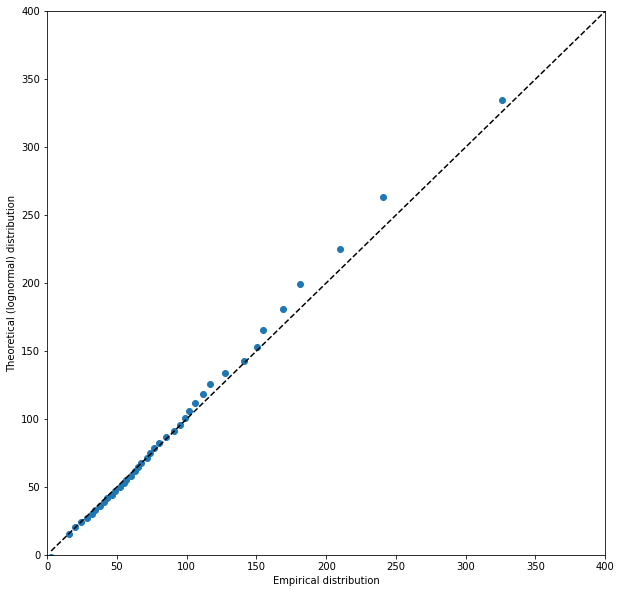

In [19]:
# Plotting a quantile biplot for empirical and theoretical (lognormal) distribution

# Calculation of quantiles
percs = np.linspace(0, 100, 41)
qn_first = np.percentile(price, percs)
qn_lognorm = scipy.stats.lognorm.ppf(percs / 100.0, *params_lognorm)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_lognorm, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (lognormal) distribution')

plt.show()

In [51]:
import sklearn.mixture

div_yield = data['Dividend Yield']

hist, bin_edges = np.histogram(div_yield, bins=30, density=True)

freq = [hist[i] for i in range(len(hist) - 1)]
positions = [(bin_edges[i] + bin_edges[i+1])/2  for i in range(len(hist) - 1)]
div_yield = div_yield[div_yield.between(div_yield.quantile(0.2), div_yield.quantile(.99))].reset_index(drop=True)
# data_to_fit = np.zeros((29, 2))
# data_to_fit[:, 0] = positions
# data_to_fit[:, 1] = freq
# gmm = sklearn.mixture.GaussianMixture(n_components=2).fit(data_to_fit)
# inidces = gmm.predict(data_to_fit)


# div_yield_0 = []
# div_yield_1 = []

# for div in div_yield:
#     div_index = 0
#     for edge in range(1, len(bin_edges)):
#         if bin_edges[edge-1] <= div < bin_edges[edge]:
#             div_index = edge
#             break
#     if inidces[div_index] == 0:
#         div_yield_0.append(div)
#     else:
#         div_yield_1.append(div)

# div_yield_0 = pd.DataFrame(div_yield_0)
# div_yield_1 = pd.DataFrame(div_yield_1)
# print(div_yield_0)
# print(div_yield_1)
# print(div_yield.describe())
# plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(div_yield)
min_amount, max_amount = div_yield.min(), div_yield.max()
x = np.linspace(min_amount, max_amount, len(div_yield))
kde_values = kernel(x)
nbins = int(5 * np.log10(len(div_yield)) + 1)
nbins=30
print('number of bins', nbins)
# sns.histplot(div_yield, kde=False, bins=nbins, stat='density', label=f'Average price in dollars')
# plt.plot(x, kde_values, color='r')


number of bins 30


iqr 1.6377541
1/4 quantile 1.37915155 3/4 quantile 3.01690565
min -1.0774795999999998 max 3.8357826999999998
median 2.0264346499999997


<AxesSubplot:>

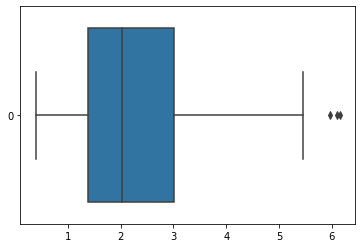

In [52]:

q1 = div_yield.quantile(0.25)
q3 = div_yield.quantile(0.75)
iqr =  q3 -  q1
print('iqr', iqr)
print('1/4 quantile', div_yield.quantile(1/4), '3/4 quantile', div_yield.quantile(3/4))
print('min', q1-1.5*iqr, 'max', q1+1.5*iqr)
print('median', div_yield.median())
sns.boxplot(data=div_yield, orient='h')

(0.41201694015435025, -0.559702695188597, 2.6121163958420297)


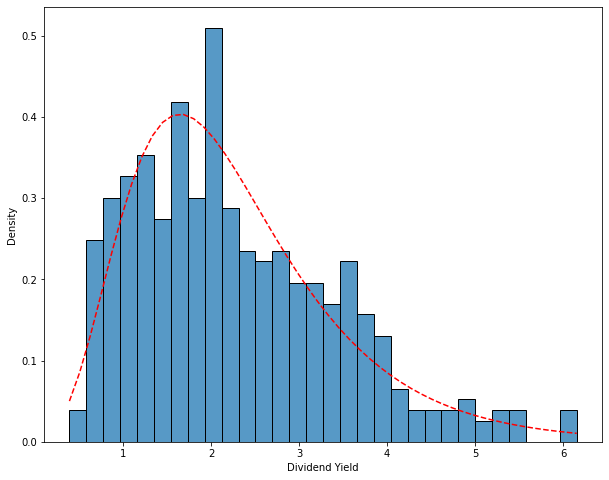

In [53]:
plt.figure(figsize=(10, 8))
sns.histplot(div_yield, kde=False, bins=nbins, stat='density', label=f'Average price in dollars')
x = np.linspace(np.min(div_yield), np.max(div_yield))
params_logn = scipy.stats.lognorm.fit(div_yield)
print(f'{params_logn}')
pdf = scipy.stats.lognorm.pdf(x, *params_logn) 
plt.plot(x, pdf, 'r--')
plt.show()


/opt/homebrew/anaconda3/envs/pandas/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


<AxesSubplot:xlabel='Dividend Yield', ylabel='Density'>

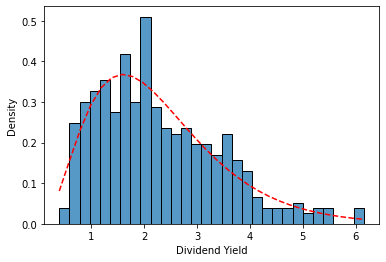

In [54]:

hist, bin_edges = np.histogram(div_yield, bins=nbins, density=True)

freq = [hist[i] for i in range(len(hist) - 1)]
positions = [(bin_edges[i] + bin_edges[i+1])/2  for i in range(len(hist) - 1)]
res, _ = scipy.optimize.curve_fit(gamma_pdf, positions, freq)

x = np.linspace(np.min(div_yield), np.max(div_yield), nbins, dtype=np.float64)
theo_probs = list(map(partial(gamma_pdf, alpha=res[0], beta=res[1]), x))
plt.plot(x, theo_probs, 'r--')
sns.histplot(div_yield, kde=False, bins=nbins, stat='density', label=f'Average price in dollars')


In [48]:
ks = scipy.stats.kstest(div_yield, 'lognorm', params_logn, N=nbins)
cm = scipy.stats.cramervonmises(div_yield, 'lognorm', params_logn)
print(ks)
print(cm)
# pvalue >= 0.05 - looks the same

KstestResult(statistic=0.03679283095779318, pvalue=0.6403391732344551)
CramerVonMisesResult(statistic=0.11725675441478117, pvalue=0.506905409553069)


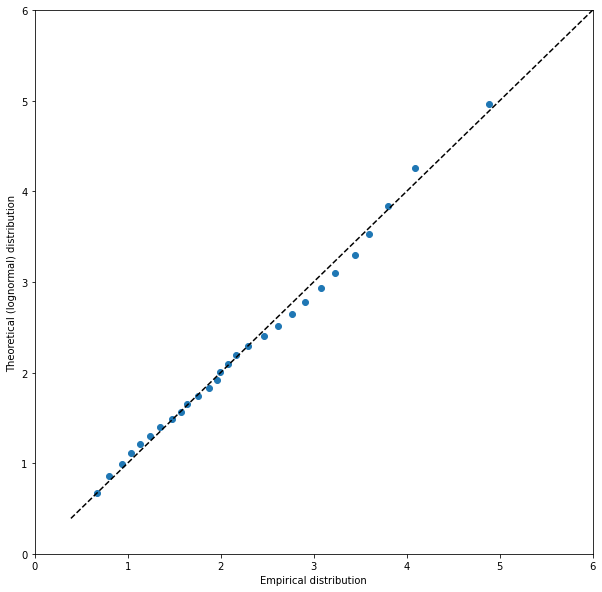

In [55]:

# Calculation of quantiles
percs = np.linspace(0, 100, nbins)
qn_first = np.percentile(div_yield, percs)
qn_gamma = scipy.stats.lognorm.ppf(percs / 100.0, *params_logn)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (lognormal) distribution')

plt.show()